In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import functools
%matplotlib inline

In [2]:
beatles_5_5 = nx.read_edgelist("./SAN-beatles-5-5-EL.csv", delimiter="\t", nodetype=str, create_using=nx.DiGraph(), data=[('rank', float),])
beatles_5_10 = nx.read_edgelist("./SAN-beatles-5-10-EL.csv", delimiter="\t", nodetype=str, create_using=nx.DiGraph(), data=[('rank', float),])
beatles_10_5 = nx.read_edgelist("./SAN-beatles-10-5-EL.csv", delimiter="\t", nodetype=str, create_using=nx.DiGraph(), data=[('rank', float),])


In [3]:
print(beatles_5_5.number_of_nodes())
print(beatles_5_5.number_of_edges())
print(beatles_5_10.number_of_nodes())
print(beatles_5_10.number_of_edges())
print(beatles_10_5.number_of_nodes())
print(beatles_10_5.number_of_edges())

372
1025
2352
7625
1663
7000


In [4]:
beatles_5_5_na = pd.read_csv("./SAN-beatles-5-5-NA.csv", delimiter="\t")
# beatles_5_5_na.followers = beatles_5_5_na.followers.astype(int)

beatles_5_10_na = pd.read_csv("./SAN-beatles-5-10-NA.csv", delimiter="\t")
# beatles_5_10_na.followers = beatles_5_10_na.followers.astype(int)

beatles_10_5_na = pd.read_csv("./SAN-beatles-10-5-NA.csv", delimiter="\t")
# beatles_10_5_na.followers = beatles_10_5_na.followers.astype(int)

In [5]:
# Assign node atrributes to nodes in the graph
def addAttributes(graph, na):
    labels = na.columns
    iter = 0

    for ID in na[labels[0]]:

        for feature in labels:
            cat = na[feature][iter]

            if type(cat) is str:
                graph.node[ID][feature] = cat

            if not type(cat) is float or not math.isnan(cat):
                graph.node[ID][feature] = cat

        iter += 1

In [6]:
# Remove nodes created from edges leading out of the graph (next level of depth)
def removeFakeNode(graph, na):
    gNodes  = graph.nodes()
    naNodes = list(na[na.columns[0]])
    
    fakeNodes = list(set(gNodes) - set(naNodes))
    graph.remove_nodes_from(fakeNodes)
    print(len(fakeNodes))

In [7]:
addAttributes(beatles_5_5, beatles_5_5_na)
addAttributes(beatles_5_10, beatles_5_10_na)
addAttributes(beatles_10_5, beatles_10_5_na)
removeFakeNode(beatles_5_5, beatles_5_5_na)
removeFakeNode(beatles_5_10, beatles_5_10_na)
removeFakeNode(beatles_10_5, beatles_10_5_na)

167
0
0


## In Degree Analysis

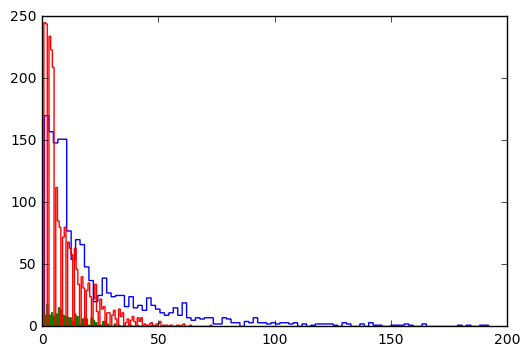

In [8]:
in_degrees_beatles_5_5 = beatles_5_5.in_degree(weight="rank")
in_degrees_beatles_5_10 = beatles_5_10.in_degree(weight="rank")
in_degrees_beatles_10_5 = beatles_10_5.in_degree(weight="rank")

    
_ = plt.hist(list(in_degrees_beatles_10_5.values()), bins=100, histtype='step')
_ = plt.hist(list(in_degrees_beatles_5_5.values()), bins=100, histtype='step')
_ = plt.hist(list(in_degrees_beatles_5_10.values()), bins=100, histtype='step')

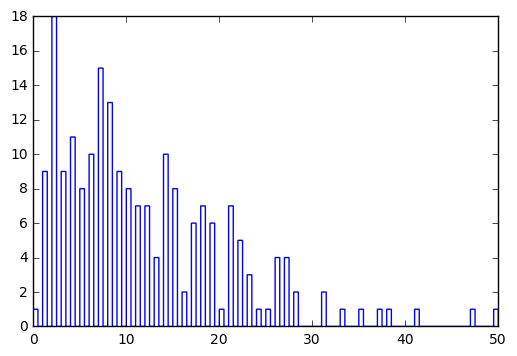

In [9]:
_ = plt.hist(list(in_degrees_beatles_5_5.values()), bins=100, histtype='step')

Observation: In-degree seems to decay exponentially.

^check with log graph

drop off at 5 or 10 because leaf nodes only have 1 in-edge always with weight 1->5 or 10

In [10]:
pop = []
fol = []
num = 0
for k,v in in_degrees_beatles_5_5.items():
    if v > 40:
#         print(beatles_5_5.node[k])
#         print("\n")
        pop.append(beatles_5_5.node[k]["popularity"])
        fol.append(beatles_5_5.node[k]["followers"])
        num += 1
for k,v in in_degrees_beatles_5_10.items():
    if v > 50:
#         print(beatles_5_10.node[k])
#         print("\n")
        pop.append(beatles_5_10.node[k]["popularity"])
        fol.append(beatles_5_10.node[k]["followers"])
        num += 1
for k,v in in_degrees_beatles_10_5.items():
    if v > 150:
#         print(beatles_10_5.node[k])
#         print("\n")
        pop.append(beatles_10_5.node[k]["popularity"])
        fol.append(beatles_10_5.node[k]["followers"])
        num += 1
        
print(sum(pop)/len(pop))
print(sum(fol)/len(fol))

40.064516129
16010.5483871


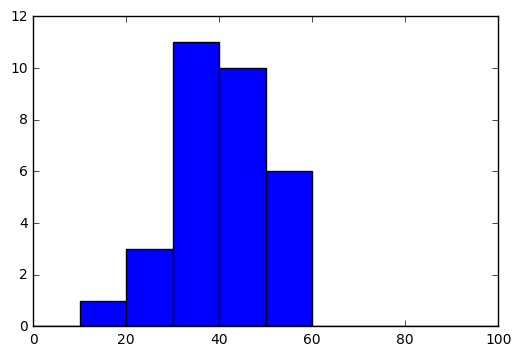

In [11]:
_ = plt.hist(pop, range=(0,100))

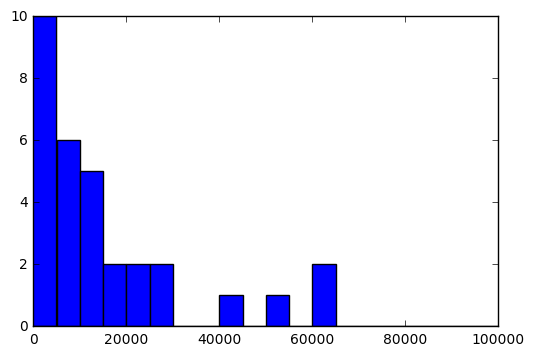

In [12]:
 _ = plt.hist(fol, range=(0, 100000), bins=20)

Observation: popularity/followers doesn't really correspond to high in-degree

## Genre Analysis

In [13]:
def genreSimilarity(gA, gB):
#     jaccard index
    total = len(list(set(gA) | set(gB)))
    same  = len(list(set(gA) & set(gB)))
    if total == 0:
        return 0
    return same/total

def getGenres(node):
    genres = []
    for g in ["genre1", "genre2", "genre3", "genre4", "genre5"]:
        if g in node:
            genres.append(node[g])
    return genres

In [14]:
def similarity(g):
    sim = []
    for s,t,d in g.edges(data=True):
        gS = getGenres(g.node[s])
        gT = getGenres(g.node[t])
        sim.append(genreSimilarity(gS, gT))
    return sim

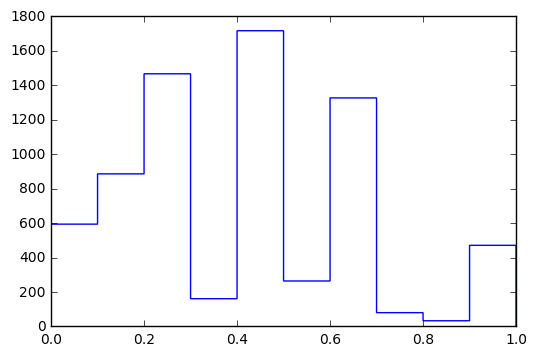

In [15]:
_ = plt.hist(similarity(beatles_10_5), histtype="step")

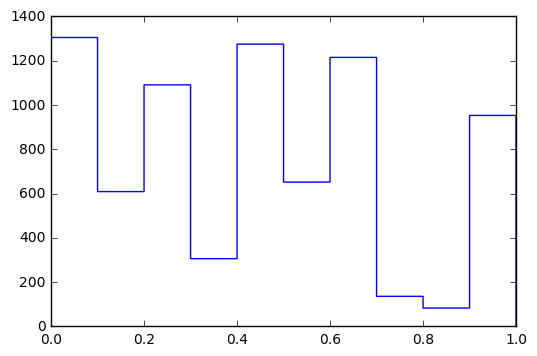

In [16]:
_ = plt.hist(similarity(beatles_5_10), histtype="step")

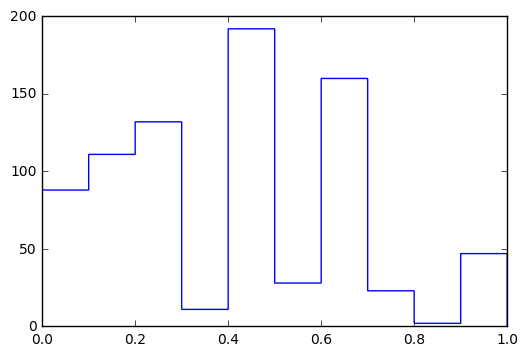

In [17]:
_ = plt.hist(similarity(beatles_5_5), histtype="step")

In [18]:
def genreList(graph):
    genres = []
    labels = ["genre1", "genre2", "genre3", "genre4", "genre5"]
    
    for n,d in graph.nodes_iter(data=True):
        for l in labels:
            if l in d:
                genres.append(d[l])
    return genres

def genreShuffle(graph):
    genres = genreList(graph)
    random.shuffle(genres)
    return genres

In [19]:
def genreReassign(graph, genres):
    genresLen = len(genres)
    iter = 0

    for ID in graph.nodes():
        for g in ["genre1", "genre2", "genre3", "genre4", "genre5"]:
            if g in graph.node[ID] and iter < genresLen:
                graph.node[ID][g] = genres[iter]
            iter += 1

In [20]:
beatles_5_5_shuf = beatles_5_5.copy()
genreReassign(beatles_5_5_shuf, genreShuffle(beatles_5_5_shuf))

beatles_5_10_shuf = beatles_5_10.copy()
genreReassign(beatles_5_10_shuf, genreShuffle(beatles_5_10_shuf))

beatles_10_5_shuf = beatles_10_5.copy()
genreReassign(beatles_10_5_shuf, genreShuffle(beatles_10_5_shuf))


print(beatles_5_10.node["2mDlls63YpRsMjgpyXxyu6"])
print(beatles_5_10_shuf.node["2mDlls63YpRsMjgpyXxyu6"])

{'genre3': 'folk rock', 'followers': 5416, 'genre4': 'mellow gold', 'genre2': 'folk', 'genre5': 'roots rock', 'level': 5, 'artist': 'Crosby & Nash', 'genre1': 'country rock', 'popularity': 39, 'id': '2mDlls63YpRsMjgpyXxyu6'}
{'genre3': 'disco', 'followers': 5416, 'genre4': 'country blues', 'id': '2mDlls63YpRsMjgpyXxyu6', 'popularity': 39, 'genre2': 'classic rock', 'artist': 'Crosby & Nash', 'genre1': 'fourth world', 'level': 5, 'genre5': 'bluesrock'}


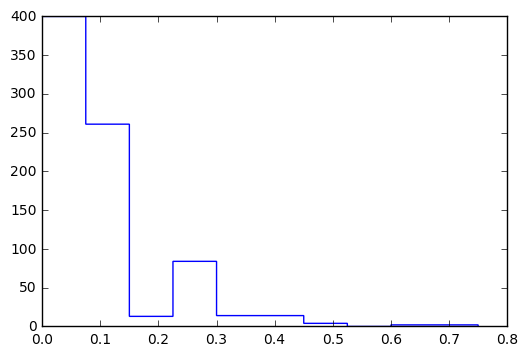

In [21]:
_ = plt.hist(similarity(beatles_5_5_shuf), histtype="step")

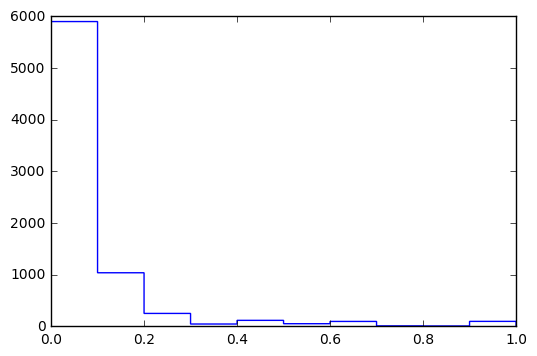

In [22]:
_ = plt.hist(similarity(beatles_5_10_shuf), histtype="step")

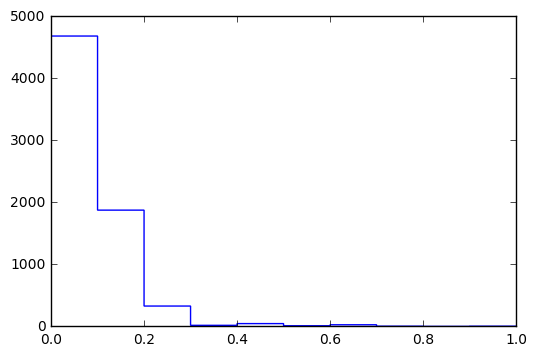

In [23]:
_ = plt.hist(similarity(beatles_10_5_shuf), histtype="step")

Observation: While genre doesn't seem to have a strong correclation with edges, it definitely has some influence.